In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
import pickle

In [2]:
# Load the data from a pickle file
with open('data/test.pickle', 'rb') as f:
    test = pickle.load(f)

# Load the data from a pickle file
with open('data/train.pickle', 'rb') as f:
    train = pickle.load(f)

In [3]:
train = train.dropna()
y_train = train['seizure']
X_train = train.drop(columns = 'seizure')

test = test.dropna()
y_test = test['seizure']
X_test = test.drop(columns = 'seizure')

In [4]:
def metrics(y_test,y_pred):
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    dict = {"metric":['sensitivity','specificity','accuracy'], 'precision':[f'{(tp/(tp+fn))*100:.3f}%', f'{(tn/(fp+tn))*100:.3f}%', f'{((tp+tn)/(tn+fp+fn+tp))*100:.3f}%']}
    return pd.DataFrame.from_dict(dict).style.hide(axis="index")

# ML

## K Neighbors

In [66]:
clf=KNeighborsClassifier(n_neighbors=60, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [67]:
metrics(y_test, y_pred)

metric,precision
sensitivity,88.337%
specificity,89.056%
accuracy,88.698%


## SVG

In [31]:
clf=SVC(kernel='linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [32]:
metrics(y_test, y_pred)

metric,precision
sensitivity,86.393%
specificity,87.768%
accuracy,87.083%


## Random forest

In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f'sensitivity: {(tp/(tp+fn))*100:.3f}%')
print(f'specificity: {(tn/(fp+tn))*100:.3f}%')
print(f'accuracy: {((tp+tn)/(tn+fp+fn+tp))*100:.3f}%')

sensitivity: 86.825%
specificity: 91.845%
accuracy: 89.343%


In [4]:
clf=RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [28]:
metrics(y_test, y_pred)

metric,precision
sensitivity,86.825%
specificity,91.845%
accuracy,89.343%


In [8]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f'sensitivity: {(tp/(tp+fn))*100:.3f}%')
print(f'specificity: {(tn/(fp+tn))*100:.3f}%')
print(f'accuracy: {((tp+tn)/(tn+fp+fn+tp))*100:.3f}%')

sensitivity: 86.825%
specificity: 91.845%
accuracy: 89.343%


# DL

## FF Neural Network

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import clear_output

c:\Users\Eugene Chen\.conda\envs\mne\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### parse dataset to tensors

In [2]:
train = train.dropna()
y_train = train['seizure']
X_train = train.drop(columns = 'seizure')

test = test.dropna()
y_test = test['seizure']
X_test = test.drop(columns = 'seizure')

NameError: name 'train' is not defined

#### data loader

In [7]:
class SeizureData(torch.utils.data.Dataset):
    def __init__(self, x_train, y_train):

        self.y_data = torch.tensor(y_train.values.astype(np.float32), requires_grad=False)
        self.x_data = torch.tensor(x_train.values.astype(np.float32), requires_grad=True)
        self.n_samples = self.x_data.shape[0]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        return self.n_samples


In [65]:
dataset = SeizureData(X_train, y_train)
train_loader = torch.utils.data.DataLoader(dataset=dataset,
                          batch_size=10,
                          shuffle=True,
                          num_workers=0)
dataset = SeizureData(X_test, y_test)
test_loader = torch.utils.data.DataLoader(dataset=dataset,
                          batch_size=10,
                          shuffle=True,
                          num_workers=0)

### Model

In [66]:
input_size = X_train.shape[1]
output_size = 1

class FFNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FFNN, self).__init__()
        # define layers
        self.lin1 = nn.Linear(input_dim, 50)
        self.lrelu = nn.LeakyReLU()
        self.lin2 = nn.Linear(50, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        y_pred = self.lin1(x)
        y_pred = self.lrelu(y_pred)
        y_pred = self.lin2(y_pred)
        y_pred = self.sigmoid(y_pred)
        return y_pred.squeeze()

model = FFNN(input_size, output_size)
print(model)

FFNN(
  (lin1): Linear(in_features=153, out_features=50, bias=True)
  (lrelu): LeakyReLU(negative_slope=0.01)
  (lin2): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


#### loss and optimization

In [51]:
learning_rate = 0.001
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [83]:
def accuracy(ys, ts):
    correct_prediction = torch.eq(ys, ts)
    return torch.mean(correct_prediction.float())

In [90]:
a = torch.tensor([1,0,1,0,1,1,0])
b = torch.tensor([1,1,1,0,0,1,1])
accuracy(a,b).data.numpy()

array(0.5714286, dtype=float32)

#### training

tensor([0, 1, 1, 1, 1, 1])
tensor(0.5000)


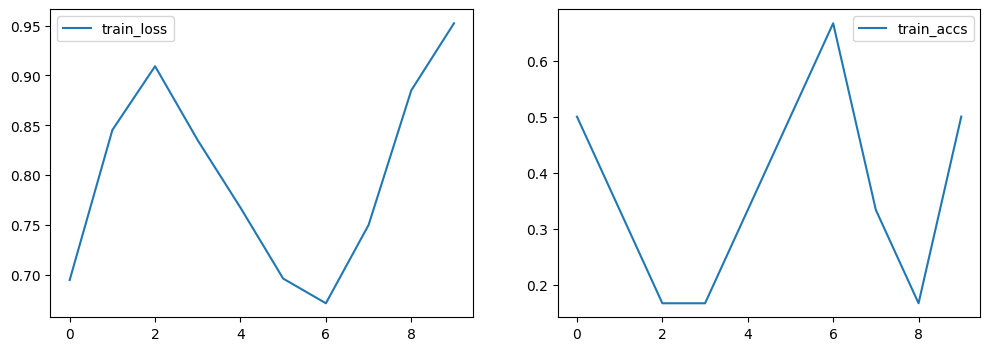

Train, it: 9 loss: 0.95 accs: 0.50


In [91]:
num_epochs = 10
num_total_steps = len(train_loader)
eval_every = 5
threshold = 0.5

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# Train the model
for epoch in range(num_epochs):
    for i, (input,label) in enumerate(train_loader):
        
        #forward
        output = model(input)
        loss = criterion(output, label)

        #backward 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_iter.append(epoch)
    train_loss.append(float(loss.data.numpy()))
    output = (output>0.5).long()
    print(output)
    print(accuracy(output, label))
    train_accs.append(float(accuracy(output, label).data.numpy()))
    fig = plt.figure(figsize=(12,4))
    plt.subplot(1, 2, 1)
    plt.plot(train_iter, train_loss, label='train_loss')
    # plt.plot(valid_iter, valid_loss, label='valid_loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_iter, train_accs, label='train_accs')
    # plt.plot(valid_iter, valid_accs, label='valid_accs')
    plt.legend()
    plt.show()
    print(f"Train, it: {epoch} loss: {train_loss[-1]:.2f} accs: {train_accs[-1]:.2f}")
    clear_output(wait=True)
            
    # if(epoch%100==0):
    #     print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{num_total_steps}], Loss: {loss.item()}')

#### testing

In [93]:
# Test the model
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for input, labels in test_loader:
        outputs = model(input)
        # max returns (value ,index)
        predicted = (outputs>0.5).float()
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network on the 1000 test is : {acc} %')

Accuracy of the network on the 1000 test is : 24.32723358449946 %


### accuracy

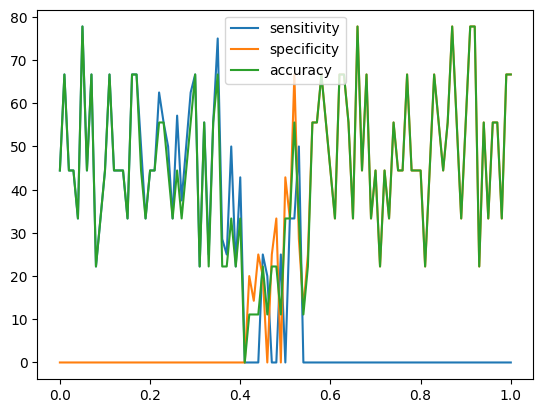

C:\Users\Eugene Chen\AppData\Local\Temp\ipykernel_13336\2756239371.py:34: RuntimeWarning: invalid value encountered in longlong_scalars
  dict = {"metric":['sensitivity','specificity','accuracy'], 'precision':[f'{(tp/(tp+fn))*100:.3f}%', f'{(tn/(fp+tn))*100:.3f}%', f'{((tp+tn)/(tn+fp+fn+tp))*100:.3f}%']}


metric,precision
sensitivity,nan%
specificity,66.667%
accuracy,66.667%


In [107]:
step = 0.01
threshold = np.arange(0, 1+step, step)

sensitivity = []
specificity = []
accuracy = []
for t in threshold:
    with torch.no_grad():
        for input, labels in test_loader:
            ttn, tfp, tfn, ttp = 0,0,0,0
            outputs = model(input)
            predicted = (outputs>t).float()
            tn, fp, fn, tp = confusion_matrix(predicted, labels, labels=[0, 1] ).ravel()
            ttn += tn
            tfp += fp
            tfn += fn
            ttp += tp
        if (ttp+tfn) == 0:
            sensitivity.append(0)
        else:
            sensitivity.append((ttp/(ttp+tfn))*100)
        if tfp+ttn == 0:
            specificity.append(0)
        else:
            specificity.append((ttn/(tfp+ttn))*100)
        accuracy.append(((ttp+ttn)/(ttn+tfp+tfn+ttp))*100)

plt.plot(threshold, sensitivity, label='sensitivity')
plt.plot(threshold, specificity, label='specificity')
plt.plot(threshold, accuracy, label='accuracy')
plt.legend()
plt.show()

dict = {"metric":['sensitivity','specificity','accuracy'], 'precision':[f'{(tp/(tp+fn))*100:.3f}%', f'{(tn/(fp+tn))*100:.3f}%', f'{((tp+tn)/(tn+fp+fn+tp))*100:.3f}%']}

pd.DataFrame.from_dict(dict).style.hide(axis="index")

In [ ]:
torch.save(model)